In [1]:
%matplotlib inline


from typing import Optional, Union

import os
import sys

import torch
import torchvision
from torch import Tensor
import torch.nn.functional as F
from torchvision.ops import boxes as box_ops
from torchvision.ops.boxes import box_area
from torchvision.ops.roi_align import _bilinear_interpolate
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

In [11]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device ', device)

main_dirpath='D:/data/'
tensor_dirpath=os.path.join(main_dirpath, 'mask_rcnn')
original_inputs=torch.load(os.path.join(tensor_dirpath, 'part-backbonefpn-orig_input.pt'), map_location=device, weights_only=True)
tfm_inputs=torch.load(os.path.join(tensor_dirpath, 'part-backbonefpn-transform.pt'), map_location=device, weights_only=False)
proposal_boxes=torch.load(os.path.join(tensor_dirpath, 'part-rpn-proposal_boxes.pt'), map_location=device, weights_only=True)
box_roi_pool=torch.load(os.path.join(tensor_dirpath, 'part-roi_head-box_roi_pool.pt'), map_location=device, weights_only=True)
print('box_features ', box_roi_pool['box_features'].shape)

device  cpu
box_features  torch.Size([800, 256, 7, 7])


In [3]:
num_classes=2
# load an instance segmentation model pre-trained on COCO
model=torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT', rpn_pre_nms_top_n_train=800,
        rpn_pre_nms_top_n_test=500,  rpn_post_nms_top_n_train=800,  rpn_post_nms_top_n_test=500, box_detections_per_img=100,
        box_batch_size_per_image =400, rpn_batch_size_per_image=100)
# get number of input features for the classifier
in_features=model.roi_heads.box_predictor.cls_score.in_features
print('the number of inpute features for classifiers ', in_features)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,  num_classes)

# get the number of input features for the mask classifiers
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
print('the number of input features for mask ', in_features_mask)
hidden_layer=256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# move model to the right device
model.to(device);

the number of inpute features for classifiers  1024
the number of input features for mask  256


[`RoIHeads`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py)

In [4]:
for name, child in model.roi_heads.named_children(): print(name)

box_roi_pool
box_head
box_predictor
mask_roi_pool
mask_head
mask_predictor


In [5]:
model.roi_heads.box_head

FastRCNNConvFCHead(
  (0): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Conv2dNormActivation(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (4): Flatten(start

In [8]:
box_features=model.roi_heads.box_head(box_roi_pool['box_features'])
print("box_roi_pool['box_features'] ", box_roi_pool['box_features'].shape, box_roi_pool['box_features'].min().item(),
     box_roi_pool['box_features'].max().item())
print('box_features ', box_features.shape, box_features.min().item(), box_features.max().item())

box_roi_pool['box_features']  torch.Size([800, 256, 7, 7]) -1.2095173597335815 1.4782435894012451
box_features  torch.Size([800, 1024]) 0.0 7.259831428527832


In [9]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

In [14]:
class_logits, box_regression=model.roi_heads.box_predictor(box_features)
print('class_logits ', class_logits.shape, class_logits.min().item(), class_logits.max().item())
print("box_roi_pool['labels'] ", [(l.shape, l.min().item(), l.max().item()) for l in box_roi_pool['labels']])
print('box_regression ', box_regression.shape, box_regression.min().item(), box_regression.max().item())
print("box_roi_pool['regression_targets'] ", [(b.shape, b.min().item(), b.max().item()) for b in box_roi_pool['regression_targets']])

class_logits  torch.Size([800, 2]) -0.8765251636505127 0.6338966488838196
box_roi_pool['labels']  [(torch.Size([400]), 0, 1), (torch.Size([400]), 0, 1)]
box_regression  torch.Size([800, 8]) -0.9376243352890015 1.2756402492523193
box_roi_pool['regression_targets']  [(torch.Size([400, 4]), -36731.43359375, 521.9777221679688), (torch.Size([400, 4]), -221.0601043701172, 1277.6134033203125)]


[`fastrcnn_loss`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L12)

```
loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
```

In [21]:
def fastrcnn_loss(class_logits:Tensor, box_regression:Tensor, labels:list[Tensor], 
                  regression_targets:list[Tensor])->tuple[Tensor, Tensor]:
    '''
    Compute loss for Faster R-CNN
    Args:
        class_logits (Tensor):
        box_regression (Tensor):
        labels (list[Tensor]):
        regression_targets (Tensor)
    Returns:
        classification_loss (Tensor)
        box_loss(Tensor)
    '''
    labels=torch.cat(labels, dim=0)
    regression_targets=torch.cat(regression_targets, dim=0)
    print('labels ', labels.shape, labels.min().item(), labels.max().item())
    print('regression_targets ', regression_targets.shape, regression_targets.min(0).values.tolist(),
         regression_targets.max(0).values.tolist())
    print('box_regression ', box_regression.shape)
    
    classification_loss=F.cross_entropy(class_logits, labels)

    # get indices that correspond to the regression targets for the corresponding ground truth labels, to used with advanced indexing
    sampled_pos_inds_subset=torch.nonzero(labels>0, as_tuple=True)[0]
    print('sampled_pos_inds_subset ', sampled_pos_inds_subset.shape)
    labels_pos=labels[sampled_pos_inds_subset]
    N, num_classes=class_logits.shape
    print('labels_pos ', labels_pos.shape, labels_pos.unique(), ' num_classes ', num_classes, ' N ', N)
    box_regression=box_regression.reshape(N, box_regression.size(-1)//4, 4) # N x num_classes x 4

    print('box_regression[sampled_pos_inds_subset, labels_pos] ', box_regression[sampled_pos_inds_subset, labels_pos].shape)
    print('regression_targets[sampled_pos_inds_subset] ', regression_targets[sampled_pos_inds_subset].shape)
    box_loss=F.smooth_l1_loss(box_regression[sampled_pos_inds_subset, labels_pos],  regression_targets[sampled_pos_inds_subset],
                             beta=1/9, reduction='sum')
    print('box_loss ', box_loss)
    box_loss=box_loss/labels.numel()
    
    return classification_loss, box_loss
loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, box_roi_pool['labels'], box_roi_pool['regression_targets'])
print('loss_box_reg ', loss_box_reg, ' loss_classifier ', loss_classifier)

labels  torch.Size([800]) 0 1
regression_targets  torch.Size([800, 4]) [-36731.43359375, -221.0601043701172, -6.826052188873291, -1.0304886102676392] [1277.6134033203125, 264.72198486328125, 34.47030258178711, 22.323680877685547]
box_regression  torch.Size([800, 8])
sampled_pos_inds_subset  torch.Size([46])
labels_pos  torch.Size([46]) tensor([1])  num_classes  2  N  800
box_regression[sampled_pos_inds_subset, labels_pos]  torch.Size([46, 4])
regression_targets[sampled_pos_inds_subset]  torch.Size([46, 4])
box_loss  tensor(133.8647, grad_fn=<SmoothL1LossBackward0>)
loss_box_reg  tensor(0.1673, grad_fn=<DivBackward0>)  loss_classifier  tensor(0.6557, grad_fn=<NllLossBackward0>)


[`postprocess_detections`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py#L671)

```
boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
```

In [57]:
def postprocess_detections(box_coder, class_logits, box_regression, proposals, image_shapes, score_thresh, nms_thresh, 
                           detections_per_img):
    '''
    Args:
        class_logits (Tensor): NxK where K is the number of classes and batch size is absorbed into N
        box_regression (Tensor): Nx(K*4) where K is the number of class
        proposals (list[Tensor]): list of Mx4 proposals/boxes, each for each image
        
    '''
    device=class_logits.device
    num_classes=class_logits.shape[-1]

    boxes_per_image=[boxes_in_image.shape[0] for boxes_in_image in proposals]
    # box_regression is Nx(K*4) and proposals is list of Mx4 
    # NxKx4 where K is the number of classes and batch size is absorbed into N
    pred_boxes=box_coder.decode(box_regression, proposals) 
    print('pred_boxes ', pred_boxes.shape)

    pred_scores=F.softmax(class_logits, -1)
    pred_boxes_list=pred_boxes.split(boxes_per_image, dim=0) # NxKx4 where batch size is not absorbed anymore, list of len=batch size
    pred_scores_list=pred_scores.split(boxes_per_image, dim=0) # NxK where batch size is not absorbed anymore, list of len=batch size
    print('pred_boxes_list ', [p.shape for p in pred_boxes_list])
    print('pred_scores_list ', [p.shape for p in pred_scores_list])
    all_boxes, all_scores, all_labels=[],[],[]
    for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, image_shapes):
        boxes=box_ops.clip_boxes_to_image(boxes, image_shape)

        # create labels for each prediction
        labels=torch.arange(num_classes, device=device)
        labels=labels.view(1,-1).expand_as(scores) # NxK
        print('labels ', labels.shape)

        # remove prediction with background label
        boxes=boxes[:,1:] # Mx1x4
        scores=scores[:,1:] # Mx1
        labels=labels[:,1:] # Mx1
        print('boxes ', boxes.shape, ' scores ', scores.shape, ' labels ', labels.shape)

        # batch everything, by making every class prediction be a separate instance
        boxes=boxes.reshape(-1,4) # Mx4
        scores=scores.reshape(-1) # M
        labels=labels.reshape(-1) # M

        # remove low scoring boxes
        inds=torch.nonzero(scores>score_thresh, as_tuple=True)[0]
        boxes, scores, labels=boxes[inds], scores[inds], labels[inds]

        # remove empty boxes
        keep=box_ops.remove_small_boxes(boxes, min_size=1e-2)
        boxes, scores, labels=boxes[keep], scores[keep], labels[keep]
        
        # non-maximum suppresion, independently done per class
        keep=box_ops.batched_nms(boxes, scores, labels, nms_thresh)
        # keep only topk scoring prediction
        keep=keep[:detections_per_img]
        boxes, scores,labels=boxes[keep], scores[keep],labels[keep]

        all_boxes.append(boxes)
        all_scores.append(scores)
        all_labels.append(labels)
        
        print('boxes ', boxes.shape, ' scores ', scores.shape, ' labels ', labels.shape)
    return all_boxes, all_scores, all_labels
boxes, scores, labels =postprocess_detections(box_coder=model.roi_heads.box_coder, class_logits=class_logits, box_regression=box_regression, 
                       proposals=box_roi_pool['proposals'], image_shapes=tfm_inputs['tfm_images'].image_sizes,
                      score_thresh=model.roi_heads.score_thresh, nms_thresh=model.roi_heads.nms_thresh,
                      detections_per_img=model.roi_heads.detections_per_img)
print('\n')
print('boxes ', [b.shape for b in boxes], ' scores ', [s.shape for s in scores], ' labels ', [l.shape for l in labels])

result:list[dict[str, torch.Tensor]]=[]

num_images=len(boxes)
for i in range(num_images):
    result.append({'boxes':boxes[i], 'labels':labels[i], 'scores':scores[i]})

pred_boxes  torch.Size([800, 2, 4])
pred_boxes_list  [torch.Size([400, 2, 4]), torch.Size([400, 2, 4])]
pred_scores_list  [torch.Size([400, 2]), torch.Size([400, 2])]
labels  torch.Size([400, 2])
boxes  torch.Size([400, 1, 4])  scores  torch.Size([400, 1])  labels  torch.Size([400, 1])
boxes  torch.Size([100, 4])  scores  torch.Size([100])  labels  torch.Size([100])
labels  torch.Size([400, 2])
boxes  torch.Size([400, 1, 4])  scores  torch.Size([400, 1])  labels  torch.Size([400, 1])
boxes  torch.Size([100, 4])  scores  torch.Size([100])  labels  torch.Size([100])


boxes  [torch.Size([100, 4]), torch.Size([100, 4])]  scores  [torch.Size([100]), torch.Size([100])]  labels  [torch.Size([100]), torch.Size([100])]


In [58]:
torch.save({'result':result},
           os.path.join(tensor_dirpath, 'part-roi_head-box_predict.pt'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.108192..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.6400003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.110678..2.64

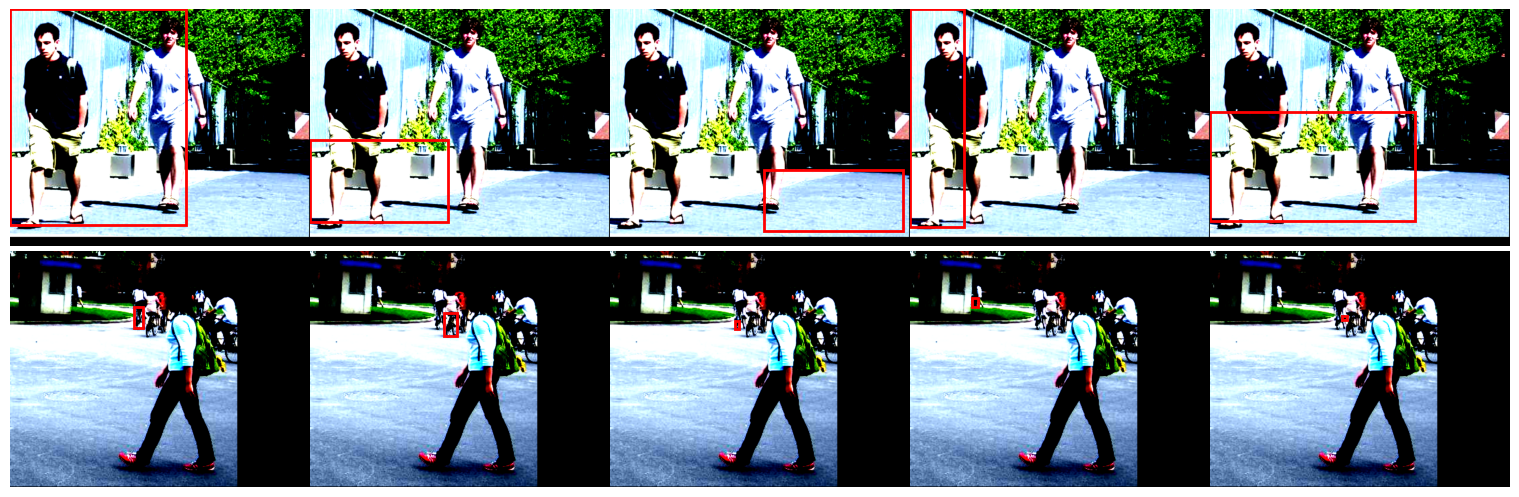

In [88]:
import matplotlib.patches as patches

topk=5
fig, axes=plt.subplots(len(boxes), topk, figsize=(15,5))
for b, (bbox_per_im,score_per_im) in enumerate(zip(boxes, scores)): 
    for k in range(topk):
        axes[b, k].imshow(tfm_inputs['tfm_images'].tensors[b].permute(1,2,0))
        width, height=[p-q for p, q in zip(bbox_per_im[k][2:].tolist(), bbox_per_im[k][:2].tolist())]
        rect = patches.Rectangle(bbox_per_im[k][:2].tolist(), width, height, linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        axes[b, k].add_patch(rect)
        axes[b, k].axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)